In [1]:
using Plots, Random, DataFrames, LinearAlgebra, Printf, JLD, Distributions, Combinatorics, MLJ, Graphs, Gurobi, JuMP, Statistics, Clustering, Distances
const GRB_ENV = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04


Gurobi.Env(Ptr{Nothing} @0x000000012eedbe00, false, 0)

### Generating points

In [2]:
function generate_points(K::Int64, N::Int64, D::Int64 , std::Float64, seed = 1234)
    """
    Generates points for the k-means problem

        input: 
            - I: number of clusters 
            - N: number of points
            - D: dimnesionality of points

        output:
            - points: NxD matrix of standardized points
    """
    Random.seed!(seed);
    X, yy = MLJ.make_blobs(N, D; centers=K, cluster_std=std)
    points = Matrix(DataFrame(X));
    min = minimum(points, dims=1);
    max = maximum(points, dims=1);
    points = (points .- min) ./ (max .- min);
    return points
end

generate_points (generic function with 2 methods)

In [3]:
struct Cluster 
    assignments::Vector{Int64}
    centroid::Vector{Float64}
    cost::Float64
end

In [4]:
function compute_cluster_centroid_cost(assignments::Vector{Int64})
    """
    Computes the centroid and cost of a cluster given the indeces of the points in the cluster

        input: 
            - assignments: Nx1 matrix of cluster assignments

        output:
            - cost of the clustering assignment
            - Vector representing the centroid of the cluster
    """

    cluster_points = points[assignments,:]

    centroid = mean(cluster_points, dims=1)

    return sum( euclidean(cluster_points[i,:],centroid) for i in 1:size(cluster_points,1)), vec(centroid)
end

compute_cluster_centroid_cost (generic function with 1 method)

In [5]:
function compute_reduced_cost(data::Cluster, p::Vector{Float64}, q::Float64)
"""
Computes the reduced cost given a dual solution of the master problem

    input: 
        - Cluster: cluster to compute the reduced cost for
        - p: dual solution of the master problem
        - q: dual solution of the master problem

    output: reduced cost of the cluster
"""

    return data.cost - sum(p[i] for i in data.assignments) - q
end

compute_reduced_cost (generic function with 1 method)

In [6]:
int(round(5/2))

DomainError: DomainError with 2.0:
Can only convert categorical elements to integers. 

### Subproblem

In [7]:
function subproblem_heuristic(data::Matrix{Float64}, p::Vector{Float64}, q::Float64, Iter::Int64)
    
    clusters = Cluster[]
    for k in 2:Int(round(size(data,1)/3))
        append!(clusters, initial_clusters(points, k, 1, Iter ))
    end
    idx = argmin([compute_reduced_cost(cluster, p, q) for cluster in clusters])
    return clusters[idx], compute_reduced_cost(clusters[idx], p, q)
end 

subproblem_heuristic (generic function with 1 method)

In [8]:
function new_cluster(data::Matrix{Float64}, p::Vector{Float64}, q::Float64, K::Int64, Iter::Int64)
    """
    Subproblem of the column generation, it returns a new cluster and its reduced cost

        input: 
            - data: Nx2 matrix of points
            - p: dual solution of the master problem
            - q: dual solution of the master problem
            - K: number of clusters
            - Iter: iteration of the column generation, this is used in the heuristics to avoid the convex hull constraint of the subproblem

        output:
            - Cluster: new cluster
            - reduced cost of the cluster
    """

    N = size(data,1)
    D = size(data,2)

    ###Subproblem
    sp_model = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes( sp_model, "OutputFlag" => 0)

    @variable(sp_model, θ[1:N])
    @variable(sp_model, a[1:N], Bin)
    @variable(sp_model, f[1:N, 1:N])
    @variable(sp_model, b[1:N-K+1], Bin)
    @variable(sp_model, γ[1:N,1:N,1:N-K+1])
    @variable(sp_model, z[1:N,1:N-K+1])

    @constraint(sp_model, [i=1:N, j=1:N], f[i,j] <= a[i])
    @constraint(sp_model, [i=1:N, j=1:N], f[i,j] <= a[j])
    @constraint(sp_model, [i=1:N, j=1:N], f[i,j] >= a[i] + a[j] - 1)
    @constraint(sp_model, sum(a[i] for i=1:N) >= 1)

    @constraint(sp_model, [i=1:N, j=1:N, l=1:N-K+1], γ[i,j,l] <= f[i,j])
    @constraint(sp_model, [i=1:N, j=1:N, l=1:N-K+1], γ[i,j,l] <= b[l])
    @constraint(sp_model, [i=1:N, j=1:N, l=1:N-K+1], γ[i,j,l] >= f[i,j] + b[l] - 1)

    @constraint(sp_model, sum(b[l] for l=1:N-K+1) == 1)

    @constraint(sp_model, [i=1:N], [θ[i]; sum( 1/l .* sum( γ[i,j,l] .* (data[i,:] .- data[j,:]) for j=1:N) for l=1:N-K+1)] in SecondOrderCone()) #
    
    ### heuristics constraint
    @constraint(sp_model, [i=1:N, l=1:N-K+1], z[i,l] >= b[l] + a[i] -1)
    @constraint(sp_model, [i=1:N, l=1:N-K+1], z[i,l] <= b[l])
    @constraint(sp_model, [i=1:N, l=1:N-K+1], z[i,l] <= a[i])
    @constraint(sp_model, [i=1:N], [5/(Iter/4); (data[i,:] .- sum(1/l .* sum( data[j,:] * z[j,l] for j in 1:N)  for l in 1:N-K+1))] in SecondOrderCone())

    @objective(sp_model, Min, sum( θ[i] - a[i]*p[i] for i in 1:N))

    optimize!(sp_model)


    #### Retrieve cluster from solution
    assignments = vec(findall(x->x>0.9, value.(a)))
    #@printf("Assignments: %s\n", value.(a))
    #@printf("Assignments: %s\n", value.(θ))
    cost, centroid = compute_cluster_centroid_cost(assignments)
    Clust = Cluster(assignments, centroid, cost)
    reduced_cost = compute_reduced_cost(Clust, p, q)

    return Clust, reduced_cost

end 

new_cluster (generic function with 1 method)

### Master problem

In [9]:
function initial_clusters(data::Matrix{Float64}, K::Int64, n_initial_clusters::Int64, seed::Int64 = 1)

    clusters = Cluster[]

    for i in 1:n_initial_clusters
        Random.seed!(seed * i)
        km =  kmeans(data', K).assignments
        for k in 1:K
            assinments = findall(x->x==k, km); 
            cost, centroid = compute_cluster_centroid_cost(assinments)
            push!(clusters, Cluster(assinments, centroid, cost))
        end
    end
    return clusters
end

initial_clusters (generic function with 2 methods)

In [10]:
function column_generation(data::Matrix{Float64}, K::Int64, n_initial_clusters::Int64, max_iterations::Int = 10000, verbose::Bool = true)

    N = size(data,1)
    
    # Initialization
    CG_solution = nothing
    CG_objective = 0.0
    upper_bounds = []
    lower_bounds = []
    MP_time = []
    SP_time = []
    p_values = []
    q_values = []

    if verbose
        @printf("              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost\n")
    end

    # Creates initial clusters
    clusters = initial_clusters(data, K, n_initial_clusters, 1)
    counter = 0

    while true
        counter += 1
        # Make restricted master problem with current clusters 
        MP_start_time = time()
        model = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
        set_optimizer_attributes(
            model,
            "OutputFlag" => 0,
        )

        @variable(model, x[r in 1:length(clusters)] ≥ 0)

        @constraint(model, points_assigned[r=1:N], sum(x[r] for r in 1:length(clusters) if r in clusters[r].assignments) == 1)
        @constraint(model, number_clusters, sum(x[r] for r in 1:length(clusters)) == K)

        @objective(model, Min, sum(x[r] * clusters[r].cost for r in 1:length(clusters)))

        optimize!(model)
        MP_end_time = time()

        ### Get duals
        p = vec(dual.(points_assigned))
        push!(p_values, p)

        q = dual.(number_clusters)
        push!(q_values, q)

        # Update column generation metrics
        push!(upper_bounds, objective_value(model))
        push!(MP_time, MP_end_time - MP_start_time)

        # Compute a new route to add and its corresponding reduced cost
        SP_start_time = time()
        #clust, reduced_cost = new_cluster(data, p, q, K, counter)
        clust, reduced_cost = subproblem_heuristic(data, p, q, counter)
        SP_end_time = time()

        # Update column generation metrics
        push!(lower_bounds, objective_value(model) + min(N * reduced_cost,0))
        push!(SP_time, SP_end_time - SP_start_time)

        if verbose
            # @printf("              | Objective | MP time (s) | SP time (s) | Reduced cost")
            @printf(
                "Iteration %3d | %9.3f | %11.3f |      %6.3f |      %6.3f | %12.3f\n",
                counter, 
                upper_bounds[end],
                lower_bounds[end],
                MP_time[end],
                SP_time[end],
                reduced_cost,
            )
        end

        # Termination criteria
        if (reduced_cost > -1e-6 || counter > max_iterations)  
            CG_solution = value.(x)
            CG_objective = objective_value(model)
            break
        end
        push!(clusters, clust)

    end

    #### solve MP with integer variables
    ############# TO DO ##################

    return Dict(
        "CG_solution" => CG_solution,
        "CG_objective" => CG_objective,
        "clusters" => clusters,
        "p_values" => p_values,
        "q_values" => q_values,
        "upper_bounds" => upper_bounds,
        "lower_bounds" => lower_bounds,
        "MP_time" => MP_time,
        "SP_time" => SP_time,
        "time_taken" => sum(MP_time) + sum(SP_time),
    )
end

column_generation (generic function with 3 methods)

In [11]:
points = generate_points(2, 20, 2, 0.9);

In [ ]:
kmeans()

In [17]:
points = generate_points(2, 100, 2, 1.0);

@time results = column_generation(points, 2, 20);

              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost
Iteration   1 |    10.489 |    -513.956 |       0.001 |       0.003 |       -5.244
Iteration   2 |     5.244 |    -508.294 |       0.001 |       0.022 |       -5.135
Iteration   3 |     5.244 |    -511.594 |       0.001 |       0.003 |       -5.168
Iteration   4 |     5.244 |    -513.825 |       0.001 |       0.003 |       -5.191
Iteration   5 |     5.244 |    -500.670 |       0.001 |       0.003 |       -5.059
Iteration   6 |     5.244 |    -508.294 |       0.001 |       0.003 |       -5.135
Iteration   7 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179
Iteration   8 |     5.244 |    -513.825 |       0.001 |       0.003 |       -5.191
Iteration   9 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179
Iteration  10 |     5.244 |    -517.259 |       0.001 |       0.003 |       -5.225
Iteration  11 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179


Iteration  12 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179
Iteration  13 |     5.244 |    -507.505 |       0.001 |       0.003 |       -5.127
Iteration  14 |     5.244 |    -508.294 |       0.001 |       0.004 |       -5.135
Iteration  15 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179
Iteration  16 |     5.244 |    -508.294 |       0.001 |       0.003 |       -5.135
Iteration  17 |     5.244 |    -502.733 |       0.001 |       0.004 |       -5.080
Iteration  18 |     5.244 |    -513.825 |       0.001 |       0.003 |       -5.191
Iteration  19 |     5.244 |    -512.697 |       0.001 |       0.004 |       -5.179
Iteration  20 |     5.244 |    -512.697 |       0.001 |       0.018 |       -5.179
Iteration  21 |     5.244 |    -500.670 |       0.001 |       0.003 |       -5.059
Iteration  22 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179
Iteration  23 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179
Iter

Iteration  32 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179
Iteration  33 |     5.244 |    -512.697 |       0.001 |       0.004 |       -5.179
Iteration  34 |     5.244 |    -508.294 |       0.001 |       0.003 |       -5.135
Iteration  35 |     5.244 |    -513.825 |       0.001 |       0.003 |       -5.191
Iteration  36 |     5.244 |    -508.294 |       0.001 |       0.003 |       -5.135
Iteration  37 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179
Iteration  38 |     5.244 |    -507.505 |       0.001 |       0.016 |       -5.127
Iteration  39 |     5.244 |    -508.294 |       0.001 |       0.003 |       -5.135
Iteration  40 |     5.244 |    -500.670 |       0.001 |       0.003 |       -5.059
Iteration  41 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179
Iteration  42 |     5.244 |    -512.697 |       0.001 |       0.003 |       -5.179
Iteration  43 |     5.244 |    -500.670 |       0.001 |       0.003 |       -5.059
Iter

Iteration  52 |     0.185 |     -11.841 |       0.001 |       0.003 |       -0.120
Iteration  53 |     0.185 |       0.185 |       0.001 |       0.003 |        0.000
  0.281013 seconds (1.25 M allocations: 293.548 MiB, 15.07% gc time)


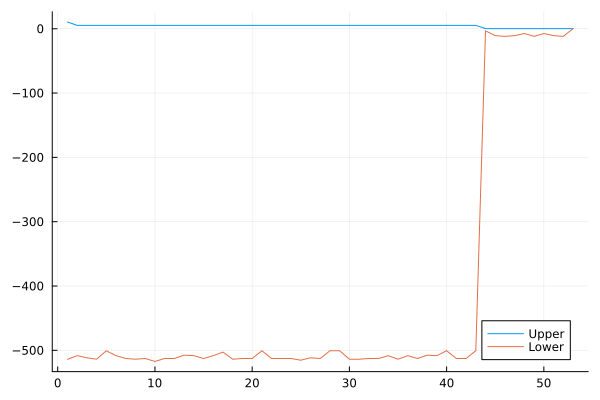

In [18]:
plot(
    1:length(results["upper_bounds"]),
    [
        results["upper_bounds"],
        results["lower_bounds"],
    ],
    legend = :bottomright,
    label = [
        "Upper" "Lower"
    ]
)

In [26]:
results["CG_objective"]

0.18530315009772527

In [20]:
points = generate_points(2, 30, 2, 1.0)

30×2 Matrix{Float64}:
 0.0456656  0.204322
 0.136156   0.0482153
 0.261297   0.130407
 0.744175   0.928949
 0.428706   0.199755
 0.682453   0.861775
 0.0        0.226949
 0.669085   0.953186
 0.563107   0.944327
 0.644745   0.986188
 ⋮          
 0.0359376  0.0911983
 0.930084   0.870475
 0.194442   0.169351
 0.0566517  0.146153
 0.812399   1.0
 0.0905108  0.0
 0.59966    0.962612
 0.013108   0.0383666
 0.149353   0.0567723

In [40]:
km_results = []
cg_results = []
for i = 20:130
    points = generate_points(2, i, 2, 1.0)
    km =  kmeans(points', 2).assignments
    clusters = Cluster[]
    for k in 1:2
        assinments = findall(x->x==k, km); 
        cost, centroid = compute_cluster_centroid_cost(assinments)
        push!(clusters, Cluster(assinments, centroid, cost))
    end
    push!(km_results, sum([c.cost for c in clusters]))

    results = column_generation(points, 2, 20, 10, false)
    push!(cg_results, results["CG_objective"])
end


In [41]:
mean(km_results)

8.383042977429199

In [42]:
mean(cg_results)

3.0067421764857825